In [169]:
import utils
import geopandas as gpd
import pandas as pd
import multiprocessing as mp
import itertools
import os
import datetime
import mapclassify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, pearsonr
from tqdm import tqdm
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings("ignore")

try:
    from matplotlib_scalebar.scalebar import ScaleBar
except:
    !pip install matplotlib_scalebar
    from matplotlib_scalebar.scalebar import ScaleBar

# Define paths
data = './data'

In [170]:
from_date = '07/01/2020'
to_date = '12/31/2021'

start_date = datetime.datetime.strptime(from_date,  "%m/%d/%Y")
end_date = datetime.datetime.strptime(to_date,  "%m/%d/%Y")

focus_date = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta

In [171]:
# County Geometry
county_geom = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'county_reference.shp'))

# TSA Geometry
tsa_geom = county_geom.dissolve(by='TSA', aggfunc='sum')
tsa_geom.reset_index(inplace=True)

# Calculate COVID-19 confirmation
ave_case = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_case.csv'))
ave_case_geom = county_geom.merge(ave_case, on='County')

# Calculate COVID-19 death 
ave_death = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_death.csv'))
ave_death_geom = county_geom.merge(ave_death, on='County')

ave_fatality_geom = ave_death_geom.copy(deep=True)
for date in focus_date:
    ave_fatality_geom[date] = ave_death_geom[date] / ave_case_geom[date] * 1000

ave_fatality_geom.fillna(0, inplace=True)

for idx, row in ave_fatality_geom.iterrows():
    for date in focus_date:
        
        if row[date] == np.inf:
            ave_fatality_geom.loc[idx, date] = ave_fatality_geom.loc[ave_fatality_geom[date] != np.inf, date].max()
            
ave_fatality_geom.head(3)

,GEOID,TSA,pop,County,geometry,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",23.809524,22.727273,20.833333,17.543860,0.000000,...,37.037037,74.074074,66.666667,100.000000,71.428571,50.000000,47.619048,57.142857,31.250000,40.000000
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",0.000000,111.111111,55.555556,47.619048,40.000000,...,41.666667,43.478261,0.000000,55.555556,32.258065,20.833333,16.949153,16.949153,16.949153,16.949153
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",20.202020,19.801980,36.697248,31.496063,32.786885,...,28.571429,23.809524,22.222222,22.222222,18.181818,18.181818,13.888889,15.151515,16.949153,20.000000


In [172]:
access_county = gpd.read_file(os.path.join(data, 'access/ICU_access_measures/ICU_access_county.shp'))
access_county.sort_values(by='index', inplace=True, ignore_index=True)
access_county.rename(columns={'NAME': 'County'}, inplace=True)
access_county.head(1)

,index,County,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry
0,48001,Anderson,0.348799,0.274023,0.276049,0.166927,0.136021,0.137165,0.136185,0.13201,...,0.027011,0.025422,0.022648,0.021609,0.019132,0.017454,0.014926,0.013797,0.012647,"POLYGON ((-95.34248 31.71803, -95.34247 31.717..."


In [173]:
county_list = county_geom['County'].tolist()
corr_state = pd.DataFrame(list(product(county_list, focus_date)), columns=['County', 'Date'])

for idx, row in tqdm(corr_state.iterrows(), total=corr_state.shape[0]):
    corr_state.loc[idx, 'access'] = access_county.loc[access_county['County'] == row['County'], row['Date']].values[0]
    corr_state.loc[idx, 'fatality'] = ave_fatality_geom.loc[ave_fatality_geom['County'] == row['County'], row['Date']].values[0]
    
# Accessibiltiy more than 1 is unnecessary
corr_state['access'].mask(corr_state['access'] > 1, 1, inplace=True)

corr_state.head()

100%|█████████████████████████████████████████| 139446/139446 [00:51<00:00, 2686.44it/s]


,County,Date,access,fatality
0,Anderson,07/01/2020,0.043240,23.809524
1,Anderson,07/02/2020,0.040854,22.727273
2,Anderson,07/03/2020,0.036800,20.833333
3,Anderson,07/04/2020,0.036226,17.543860
4,Anderson,07/05/2020,0.036697,0.000000


In [174]:
## For static values
# Caclulate covid-19 cases per census tract
d_val = pd.read_csv('./data/reference_data/covid_data/daily_covid_case.csv')
d_val.set_index('County', inplace=True)
d_val = d_val.sum(axis=1)
d_val = pd.DataFrame(d_val, columns=['cases_county'])

death = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'daily_covid_death.csv'))
death = death.set_index('County')
death = death.sum(axis=1)
death = pd.DataFrame(death, columns=['death_county'])
fatality = d_val.merge(death, left_index=True, right_index=True)
fatality.reset_index(inplace=True)
fatality.head(3)

,County,cases_county,death_county
0,Anderson,5877.0,207
1,Andrews,2462.0,65
2,Angelina,6762.0,403


In [175]:
fatality = county_geom.merge(fatality, on='County')
fatality['mortality'] = fatality['death_county'] / fatality['pop'] * 100000
fatality['fatality'] = fatality['death_county'] / fatality['cases_county'] * 1000
fatality.head(3)

,GEOID,TSA,pop,County,geometry,cases_county,death_county,mortality,fatality
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",5877.0,207,358.069538,35.222052
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",2462.0,65,360.390330,26.401300
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",6762.0,403,461.510272,59.597752


In [176]:
access_county_s = gpd.read_file(os.path.join(data, 'access/ICU_access_measures/static_measurement/ICU_access_county_static.shp'))
# access_tract_s = access_tract_s.merge(d_loc[['GEOID', 'cases_tract']], on='GEOID')
access_county_s.head(5)

,GEOID,TSA,pop,County,access,geometry
0,48001,G,57810,Anderson,0.002099,"POLYGON ((1440392.625 1070275.995, 1440394.136..."
1,48003,J,18036,Andrews,0.002414,"POLYGON ((792219.493 1130103.506, 792219.283 1..."
2,48005,H,87322,Angelina,0.005809,"POLYGON ((1527772.708 998471.159, 1527771.700 ..."
3,48007,U,24462,Aransas,0.000872,"POLYGON ((1274596.986 661976.640, 1275197.203 ..."
4,48009,C,8716,Archer,0.001200,"POLYGON ((1146052.762 1278817.953, 1146055.620..."


KendalltauResult(correlation=0.11371708655686906, pvalue=0.006977599040087898)
KendalltauResult(correlation=-0.1117108591801594, pvalue=0.0)


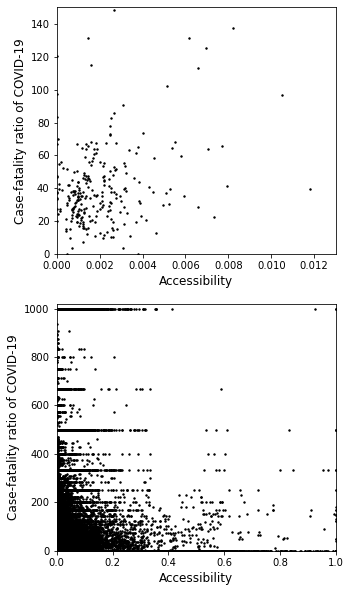

In [242]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

# Static
print(kendalltau(access_county_s['access'], fatality['fatality']))
axes[0].scatter(access_county_s['access'], fatality['fatality'],  color='black', s=2)
axes[0].set_xlabel('Accessibility', fontsize=12)
axes[0].set_ylabel('Case-fatality ratio of COVID-19', fontsize=12)
# axes[0].yaxis.set_label_position("right")
# axes[0].yaxis.set_ticks_position("right")
axes[0].set_ylim(0, 150)
axes[0].set_xlim(0, 0.013)

# Dynamic
print(kendalltau(corr_state['access'], corr_state['fatality']))
axes[1].scatter(corr_state['access'], corr_state['fatality'],  color='black', s=2)
axes[1].set_xlabel('Accessibility', fontsize=12)
axes[1].set_ylabel('Case-fatality ratio of COVID-19', fontsize=12)
# axes[1].yaxis.set_label_position("right")
# axes[1].yaxis.set_ticks_position("right")
# axes[1].yaxis.tick_right()

axes[1].set_ylim(0, 1020)
axes[1].set_xlim(0, 1)

plt.show()

In [179]:
kendall_dict = dict()
no_access_county = list()

for idx, row in county_geom.iterrows():
    acc_ts = access_county.loc[access_county['County'] == row['County'], focus_date].values[0]
    
    if acc_ts.max() > 1:
        print(f"{row['County']}: Extraordinary Access")
        acc_ts[acc_ts > 1] = 1
    
    death_ts = ave_fatality_geom.loc[ave_fatality_geom['County'] == row['County'], focus_date].values[0]
    tau, taup = kendalltau(acc_ts, death_ts)
    
    kendall_dict[row['GEOID']] = dict()
    if tau is np.nan:
        kendall_dict[row['GEOID']]["coef"] = np.nan
        kendall_dict[row['GEOID']]["pval"] = np.nan
        kendall_dict[row['GEOID']]["notes"] = 'error'
    
    else:
        
        if taup < 0.05:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'significant'
        
        else:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'not significant'

    
coefs = [kendall_dict[ind]["coef"] for ind in county_geom["GEOID"]]
pvals = [kendall_dict[ind]["pval"] for ind in county_geom["GEOID"]]
notes = [kendall_dict[ind]["notes"] for ind in county_geom["GEOID"]]

# Convert Dictionary to DataFrame
kendall_df = pd.DataFrame({"GEOID": county_geom["GEOID"], "coefs": coefs, "pvals": pvals, "notes": notes})
kendall_df['GEOID'] = kendall_df['GEOID'].astype(str)

kendall_gdf = county_geom.merge(kendall_df, on='GEOID')
kendall_gdf.head(3)

Bowie: Extraordinary Access
Brewster: Extraordinary Access
Childress: Extraordinary Access
Concho: Extraordinary Access
Culberson: Extraordinary Access
Kimble: Extraordinary Access
Lubbock: Extraordinary Access
Ochiltree: Extraordinary Access
Reagan: Extraordinary Access
Runnels: Extraordinary Access
Schleicher: Extraordinary Access
Sutton: Extraordinary Access
Tom Green: Extraordinary Access
Upton: Extraordinary Access
Webb: Extraordinary Access
Zapata: Extraordinary Access


,GEOID,TSA,pop,County,geometry,coefs,pvals,notes
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",-0.090117,1.998459e-03,significant
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",-0.371057,9.372297e-33,significant
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",-0.043911,1.268022e-01,not significant


### Plot Correlation results

In [180]:
mapclassify.FisherJenks(kendall_gdf.loc[kendall_gdf['notes'] == 'significant', 'coefs'])

FisherJenks           

   Interval      Count
----------------------
[-0.43, -0.31] |    43
(-0.31, -0.22] |    69
(-0.22, -0.14] |    58
(-0.14, -0.06] |    38
(-0.06,  0.23] |     6

In [181]:
county_geom

,GEOID,TSA,pop,County,geometry
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136..."
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1..."
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ..."
3,48007,U,24462,Aransas,"POLYGON ((1274596.986 661976.640, 1275197.203 ..."
4,48009,C,8716,Archer,"POLYGON ((1146052.762 1278817.953, 1146055.620..."
...,...,...,...,...,...
249,48499,G,44366,Wood,"POLYGON ((1453300.416 1186211.472, 1453300.470..."
250,48501,B,8631,Yoakum,"POLYGON ((758198.913 1216450.100, 758196.993 1..."
251,48503,C,18036,Young,"POLYGON ((1128414.929 1247487.578, 1128741.058..."
252,48505,T,14304,Zapata,"POLYGON ((1083961.136 569160.648, 1084088.878 ..."


In [246]:
no_access_county = access_county_s.loc[access_county_s['access'] == 0, 'County'].to_list()
no_access_county

['Dickens',
 'Edwards',
 'Hudspeth',
 'Jeff Davis',
 'Jim Hogg',
 'Kenedy',
 'Motley',
 'Presidio',
 'Real',
 'Terrell']

In [250]:
kendall_gdf.loc[kendall_gdf['County'].isin(no_access_county)].shape[0]

10

In [251]:
kendall_gdf.loc[(kendall_gdf['notes'] != 'significant')& (~kendall_gdf['County'].isin(no_access_county))].shape[0]

30

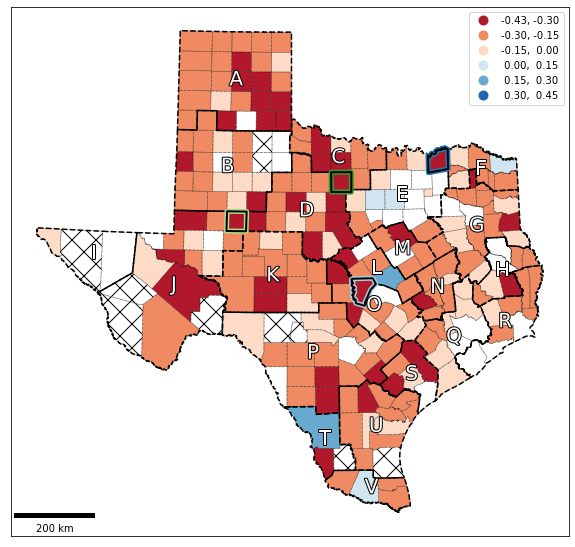

In [249]:
# Define color map
color_brewer = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=6)

fig, ax = plt.subplots(figsize=(10,10))

ud = mapclassify.UserDefined(kendall_gdf['coefs'], [-0.3, -0.15, 0, 0.15, 0.3, 0.45])
kendall_gdf.loc[kendall_gdf['notes'] == 'significant'].plot('coefs', ax=ax, cmap=cm, legend=True, scheme='UserDefined', classification_kwds={'bins': ud.bins})
kendall_gdf.loc[(kendall_gdf['notes'] != 'significant')& (~kendall_gdf['County'].isin(no_access_county))].plot(ax=ax, color='white')  # Locations with insignificant pearsonr correlation
kendall_gdf.loc[kendall_gdf['County'].isin(no_access_county)].plot(ax=ax, hatch='X', color='white')  # Locations without access to icu beds
# kendall_gdf.loc[(kendall_gdf['notes'] == 'error')].plot(ax=ax, hatch='X', color='white')  # Locations without access to icu beds

county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

# coi = ['Hutchinson', 'Burnet', 'Fannin', 'Hill', 'Howard', 'Young']
coi = ['Burnet', 'Fannin', 'Howard', 'Young']
color_bar = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

for idx, temp_county in enumerate(coi):
    county_geom.boundary[county_geom['County'] == temp_county].plot(ax=ax, lw=2, color='black', path_effects=[pe.withStroke(linewidth=5, foreground=color_bar[idx])])


In [183]:
def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_

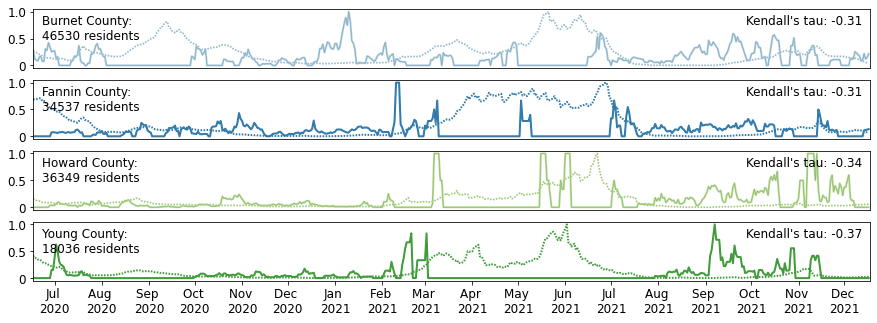

In [239]:
coi = ['Burnet', 'Fannin', 'Howard', 'Young']
# coi = ['Hutchinson', 'Burnet', 'Fannin', 'Hill', 'Howard', 'Young']
color_bar = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]


fig, axes = plt.subplots(len(coi), 1, figsize=(15, 5))

for idx, temp_county in enumerate(coi):

    fatality_ts = ave_fatality_geom.loc[ave_fatality_geom['County'] == temp_county, focus_date].values[0]
    fatality_ts[fatality_ts > 1000] = 1000
    axes[idx].plot(normalize(fatality_ts), color='grey', linewidth=0.3, path_effects=[pe.withStroke(linewidth=2, foreground=color_bar[idx])])
    

    access_ts = access_county.loc[access_county['County'] == temp_county, focus_date].values[0]
    axes[idx].plot(normalize(access_ts), color='grey', linestyle=(0, (5, 5)), linewidth=0.3, path_effects=[pe.withStroke(linewidth=2, foreground=color_bar[idx])])
    
    temp_county_pop = ave_fatality_geom.loc[ave_fatality_geom['County'] == temp_county, 'pop'].values[0]
    axes[idx].text(0.01, 0.9, f'{temp_county} County: \n{temp_county_pop} residents', size=12, ha='left', va='top',transform=axes[idx].transAxes)
    
    temp_corr = round(kendall_gdf.loc[kendall_gdf['County'] == temp_county, 'coefs'].values[0], 2)
    axes[idx].text(0.99, 0.9, f"Kendall's tau: {temp_corr}", size=12, ha='right', va='top',transform=axes[idx].transAxes)
    axes[idx].set_xlim(0, len(focus_date))
    axes[idx].set_yticks([0, 0.5, 1.0])
    axes[idx].set_yticklabels([0, 0.5, 1.0], fontsize=12)
    
    if idx == len(coi) - 1:
#         pass
        axes[idx].set_xticks([focus_date.index(val) for val in period])
        axes[idx].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period], fontsize=12)
    else:
        axes[idx].get_xaxis().set_visible(False)  # Remove ticks and labels
#         axes[idx].get_yaxis().set_visible(False)  # Remove ticks and labels
